In [143]:
## Import Packages

In [33]:
#Import packages
import math
import numpy as np
import pandas as pd
from lmfit import Model, Parameters
import matplotlib.pyplot as plt
from lmfit import Model, Parameters
import matplotlib.font_manager
from matplotlib.pyplot import figure
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({
    "text.usetex": True,
    "font.weight": "bold",
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]})

In [34]:
#import data, load data into arrays and define axes 

FA   = pd.read_csv("Readings/CSV/Frequency-Amplitude.csv") 
FP   = pd.read_csv("Readings/CSV/Frequency-PhaseShift.csv")
LFA  = pd.read_csv("Readings/CSV/LockIn-Frequency-Amplitude.csv")
LFP  = pd.read_csv("Readings/CSV/LockIn-Frequency-PhaseShift.csv")

FA   = np.array(FA) 
FP   = np.array(FP)
LFA  = np.array(LFA)
LFP  = np.array(LFP)

fa_frequency   = FA[:,2]
fa_amplitude   = FA[:,1]
fp_frequency   = FP[:,2]
fp_phaseshift  = FP[:,1]
lfa_frequency  = LFA[:,2]
lfa_amplitude  = LFA[:,1]
lfp_frequency  = LFP[:,2]
lfp_phaseshift = LFP[:,1]


In [35]:
# Define functions

def Filter(freq,R,C):
    omega = 2*np.pi*freq
    vout=( 1./(1j*R*omega*C+1.))
    return(vout)

In [62]:
amp_min = lfa_amplitude.min()
amp_max = lfa_amplitude.max()

In [36]:
#Define constants in our circuit

C = 0.022e-6 # 0.022 microFarads
R = 1.5e6 # 1.5 megaOhms
tau = R*C # We calculate the time constant since we need it all over our plots

In [48]:
#calculate the cut off frequency

f = np.linspace(10,10000,1000)
vout_c = Filter(f,R,C)
F_cut = 1./(2.*np.pi*tau)
print("Filter cut off frequency is: {:7.2f} KHz".format(F_cut))

Filter cut off frequency is:    4.82 KHz


In [38]:
def graph(formula, x_range):  
    x = np.array(x_range)  
    y = formula(x)# <- note now we're calling the function 'formula' with x
    
  #  plt.plot(x, y)  
  #  plt.show() 

def amplitude_fit(x):
    value = 320/np.sqrt(1+(2*np.pi*tau*x)**2)
    return value

graph(amplitude_fit, range(0, 100000))

def phase_shift_fit(x):
    ps_value = -180/pi*np.arctan(2*np.pi*tau*x)
    return ps_value

In [39]:
def Amplitude_of_Filter(x,amp,tau):
    lfa_amplitude=amp/np.sqrt(1+(2*np.pi*tau*x)**2)
    return lfa_amplitude

def Phase_Shift_of_Filter(x,tau,offset):
    lfp_phaseshift=-180/np.pi*np.arctan(2*np.pi*tau*x)+offset
    return lfp_phaseshift

In [40]:
amp_model = Model(Amplitude_of_Filter)
ps_model  = Model(Phase_Shift_of_Filter)

In [41]:
print ("Amplitude Independent vars: ", amp_model.independent_vars) #print out to confirm what we just did
print ("Amplitude Parameters: ", amp_model.param_names)

print ("Phase Shift Independent vars: ", ps_model.independent_vars) #print out to confirm what we just did
print ("Phase Shift Parameters: ", ps_model.param_names)

Amplitude Independent vars:  ['x']
Amplitude Parameters:  ['amp', 'tau']
Phase Shift Independent vars:  ['x']
Phase Shift Parameters:  ['tau', 'offset']


In [42]:
p_a = Parameters()
p_a.add_many(('amp', lfa_amplitude.mean(), True, 0, lfa_amplitude.max(), None), # params for first fit, 
           ('tau', tau, False, None, None, None))

p_ps = Parameters()
p_ps.add_many(('tau', tau, True, None, None, None),('offset', 0, False, None, None, None))


In [43]:
amp_result = amp_model.fit(lfa_amplitude, x=lfa_frequency, params=p_a, weights = None )

ps_result = ps_model.fit(lfp_phaseshift, x=lfp_frequency, params=p_ps, weights = None )

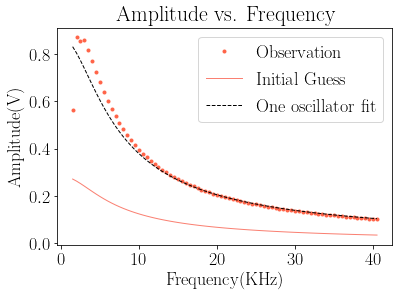

In [44]:
plt.plot(lfa_frequency,lfa_amplitude,'.', c="tomato", label="Observation")
plt.plot(lfa_frequency, amp_result.init_fit, '-', c="salmon", label="Initial Guess", linewidth=1)
plt.plot(lfa_frequency, amp_result.best_fit, '--', c="black",label="One oscillator fit", linewidth=1)
plt.xlabel("Frequency(KHz)")
plt.ylabel("Amplitude(V)")
plt.title("Amplitude vs. Frequency")
plt.legend()
plt.savefig("Images/LA- Amplitude Fit.pdf", bbox_inches='tight')
plt.show()

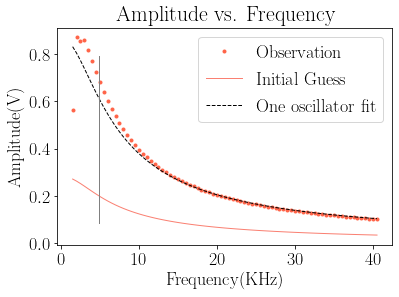

In [67]:
# Same plot, but add the cut off frequency

plt.plot(lfa_frequency,lfa_amplitude,'.', c="tomato", label="Observation")
plt.plot(lfa_frequency, amp_result.init_fit, '-', c="salmon", label="Initial Guess", linewidth=1)
plt.plot(lfa_frequency, amp_result.best_fit, '--', c="black",label="One oscillator fit", linewidth=1)
plt.axvline(x=4.82, ymin=amp_min, ymax=amp_max, c='grey', lw='1')
plt.xlabel("Frequency(KHz)")
plt.ylabel("Amplitude(V)")
plt.title("Amplitude vs. Frequency")
plt.legend()
plt.savefig("Images/Cut Off LA - Amplitude Fit.pdf", bbox_inches='tight')
plt.show()

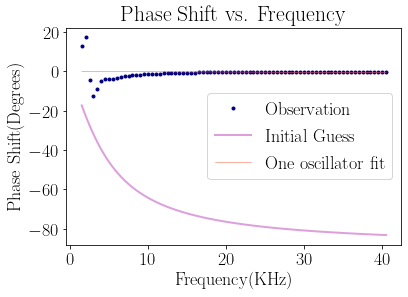

In [46]:
plt.plot(lfp_frequency,lfp_phaseshift,'.', c="navy",  label="Observation")
plt.plot(lfp_frequency, ps_result.init_fit, '-', c="plum", label="Initial Guess", linewidth=2)
plt.plot(lfa_frequency, ps_result.best_fit, '-', c="tomato", label="One oscillator fit", linewidth=0.5)
plt.xlabel("Frequency(KHz)")
plt.ylabel("Phase Shift(Degrees)")
plt.title("Phase Shift vs. Frequency")
plt.legend()
plt.savefig("Images/LP-Phase Shift Fit.pdf", bbox_inches='tight')
plt.show()

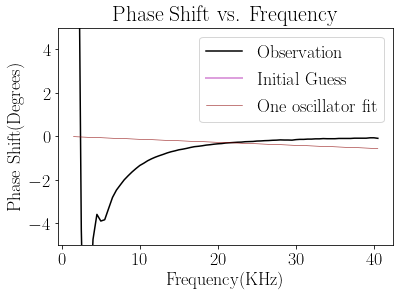

In [75]:
# Do the same plot but zoomed in, to focus on the observation/ one oscillator fit 

plt.plot(lfp_frequency,lfp_phaseshift,'-', c="k",  label="Observation")
plt.plot(lfp_frequency, ps_result.init_fit, '-', c="plum", label="Initial Guess", linewidth=2)
plt.plot(lfa_frequency, ps_result.best_fit, '-', c="darkred", label="One oscillator fit", linewidth=0.5)
plt.xlabel("Frequency(KHz)")
plt.ylabel("Phase Shift(Degrees)")
plt.ylim(-5,5)
plt.title("Phase Shift vs. Frequency")
plt.legend()
plt.savefig("Images/Zoomed LP-Phase Shift Fit.pdf",bbox_inches='tight')
plt.show()